In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_dir = "/content/gdrive/My Drive/MachineLearning/PlantIll/"
base_dir = root_dir + 'DPModel'

In [3]:
!pip install -q torch==1.0.0 torchvision

     |████████████████████████████████| 591.8MB 31kB/s 
ERROR: torchvision 0.4.1+cu100 has requirement torch==1.3.0, but you'll have torch 1.0.0 which is incompatible.


In [0]:
from fastai import *
from fastai.vision import *
from fastai.widgets import *
import torchvision.models
import torch
from torch.nn.parameter import Parameter
from torch.nn import functional as F
from torch.nn.modules.conv import _ConvNd
from torch.nn.modules.utils import _pair
import torch.nn as nn

In [0]:
%reload_ext autoreload 
%autoreload 2
%matplotlib inline

In [0]:
#change directory to where we have our project
import os 
os.getcwd()
os.chdir('/content/gdrive/My Drive/MachineLearning/PlantIll') 

# Getting the data

In [0]:
## our datapath
path = Path('/content/gdrive/My Drive/Datasets/PlantVillage')
dest = path
dest.mkdir(parents=True, exist_ok=True)

In [8]:
path.ls()

[PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/val'),
 PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/train'),
 PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/models'),
 PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/tmp.pth'),
 PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/test.jpg')]

In [0]:
##### Data **augmentation** 
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
np.random.seed(42)
src  = ImageList.from_folder(path)

In [0]:
sd = (src.split_by_folder(train='train', valid='val'))

In [0]:
labellists =(sd.label_from_folder())

In [0]:
##batch size 
bs= 128
## we will use it in progrissive resizing at the beggining it was 256//2
img_size = 256//2

In [0]:
labellists = (labellists.transform(tfms , size=img_size))

In [0]:
## our data bunch, it contains ou data loaders 
data =  labellists.databunch(bs=bs).normalize(imagenet_stats)

In [16]:
print(data.classes)
len(data.classes),data.c

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

(39, 39)

# Our Model 

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [0]:
#https://github.com/iKintosh/GaborNet

class GaborConv2d(_ConvNd):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=False):
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)

        super(GaborConv2d, self).__init__(in_channels, out_channels, kernel_size, stride, padding, dilation, False, _pair(0), groups, bias)
        self.freq = nn.Parameter((3.14/2)*1.41**(-torch.randint(0, 5, (out_channels, in_channels))).type(torch.Tensor))
        self.theta = nn.Parameter((3.14/8)*torch.randint(0, 8, (out_channels, in_channels)).type(torch.Tensor))
        self.psi = nn.Parameter(3.14*torch.rand(out_channels, in_channels))
        self.sigma = nn.Parameter(3.14/self.freq)
        self.x0 = torch.ceil(torch.Tensor([self.kernel_size[0]/2]))[0]
        self.y0 = torch.ceil(torch.Tensor([self.kernel_size[1]/2]))[0]

    def forward(self, input):
        y, x = torch.meshgrid([torch.linspace(-self.x0+1, self.x0, self.kernel_size[0]), torch.linspace(-self.y0+1, self.y0, self.kernel_size[1])])
        x = x.to(device)
        y = y.to(device)
        weight = torch.empty(self.weight.shape, requires_grad=False).to(device)
        for i in range(self.out_channels):
            for j in range(self.in_channels):
                sigma = self.sigma[i, j].expand_as(y)
                freq = self.freq[i, j].expand_as(y)
                theta = self.theta[i, j].expand_as(y)
                psi = self.psi[i, j].expand_as(y)

                rotx = x * torch.cos(theta) + y * torch.sin(theta)
                roty = -x * torch.sin(theta) + y * torch.cos(theta)

                g = torch.zeros(y.shape)

                g = torch.exp(-0.5 * ((rotx ** 2 + roty ** 2) / (sigma + 1e-3) ** 2))
                g = g * torch.cos(freq * rotx + psi)
                g = g / (2*3.14*sigma**2)
                weight[i, j] = g
                self.weight.data[i, j] = g
        return F.conv2d(input, weight, self.bias, self.stride, self.padding, self.dilation, self.groups)



In [19]:
gabor_model = torchvision.models.vgg16(pretrained = True)
nf = data.c # number of output classes in your data

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:15<00:00, 35481862.73it/s]


In [0]:
for param in gabor_model.parameters():
  param.requires_grad = False

In [0]:
num_ftrs2 = gabor_model.classifier[6].in_features
gabor_model.classifier[6] = nn.Linear(num_ftrs2, nf)

In [22]:
gabor_model.features[0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [0]:
gabor_model.features[0] = GaborConv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

In [0]:
gabor_model = gabor_model.cuda()

In [0]:
## fbeta is F1 score fbeta,
learn = Learner(data, gabor_model, metrics=[accuracy])

In [26]:
learn.model

VGG(
  (features): Sequential(
    (0): GaborConv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), bias=False)
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

In [27]:
learn.summary()

VGG
Layer (type)         Output Shape         Param #    Trainable 
GaborConv2d          [64, 31, 31]         23,232     True      
______________________________________________________________________
ReLU                 [64, 31, 31]         0          False     
______________________________________________________________________
Conv2d               [64, 31, 31]         36,928     False     
______________________________________________________________________
ReLU                 [64, 31, 31]         0          False     
______________________________________________________________________
MaxPool2d            [64, 15, 15]         0          False     
______________________________________________________________________
Conv2d               [128, 15, 15]        73,856     False     
______________________________________________________________________
ReLU                 [128, 15, 15]        0          False     
__________________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


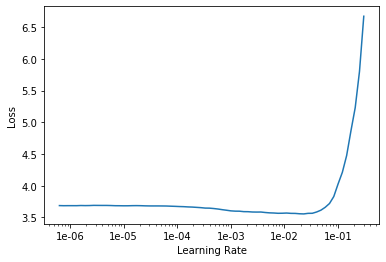

In [28]:
learn.lr_find()
learn.recorder.plot()

# Train the model

In [30]:
learn.fit_one_cycle(7, max_lr=slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,3.218417,3.077038,0.198793,51:07
1,2.803397,2.687331,0.268410,04:23
2,2.624836,2.487182,0.312345,04:20
3,2.487195,2.373778,0.355043,04:20
4,2.409384,2.314332,0.357828,04:21
5,2.378274,2.290472,0.363861,04:22
6,2.368805,2.286197,0.369276,04:24


In [0]:
learn.save('gabor-VGG16-weight-1')

Plotting Losses


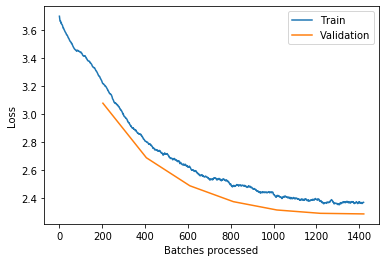

In [32]:
print("Plotting Losses")
learn.recorder.plot_losses()


Plotting metrics


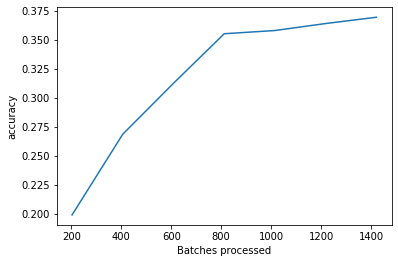

In [33]:
print("Plotting metrics")
learn.recorder.plot_metrics()


Plotting LR


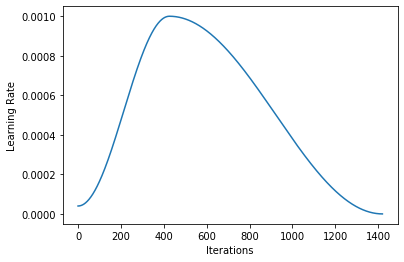

In [34]:
print("Plotting LR")
learn.recorder.plot_lr()

In [0]:
learn.load('gabor-VGG16-weight-1');

In [0]:
learn.unfreeze()

In [37]:
learn.fit_one_cycle(7, max_lr=slice(1e-3, 6e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.472905,1.363024,0.594369,05:08
1,1.397645,1.486919,0.602104,05:08
2,1.131047,1.004860,0.700959,05:07
3,0.851875,0.662337,0.796720,05:07
4,0.552444,0.449767,0.870359,05:09
5,0.362410,0.314521,0.904548,05:11
6,0.278664,0.274151,0.913676,05:12


In [0]:
learn.save('gabor-VGG16-weight-2')

In [0]:
# before we start the last phase of training we change img_size = 256//2 to img_size = 256
# this change is called progrissive resizing in fastai this method helps
# the model to learn and get a better accuracy 

In [0]:
##batch size 
bs= 128
## we will use it in progrissive resizing at the beggining it was 256//2
img_size = 256

In [0]:
labellists = (labellists.transform(tfms , size=img_size))
data =  labellists.databunch(bs=bs).normalize(imagenet_stats)

In [0]:
gabor_model = torchvision.models.vgg16(pretrained = True)
nf = data.c # number of output classes in your data

In [0]:
for param in gabor_model.parameters():
  param.requires_grad = False

In [0]:
num_ftrs2 = gabor_model.classifier[6].in_features
gabor_model.classifier[6] = nn.Linear(num_ftrs2, nf)

In [0]:
gabor_model.features[0] = GaborConv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

In [0]:
gabor_model = gabor_model.cuda()

In [0]:
learn = Learner(data, gabor_model, metrics=[accuracy])

In [0]:
learn.load('gabor-VGG16-weight-2');

In [49]:
learn.freeze_to(-2)
learn.fit_one_cycle(7, max_lr=slice(1e-3, 6e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.623265,0.643671,0.810798,07:36
1,0.942979,0.778705,0.779548,07:30
2,0.869052,0.581359,0.839728,07:34
3,0.499180,0.395842,0.893100,07:33
4,0.312889,0.266661,0.924969,07:34
5,0.164169,0.177022,0.949876,07:35
6,0.105242,0.131749,0.962717,07:37


In [0]:
learn.save('gabor-VGG16-weight-3')

In [0]:
learn.load('gabor-VGG16-weight-3');

In [52]:
learn.freeze_to(-3)
learn.fit_one_cycle(10, max_lr=slice(1e-3, 6e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.139789,0.245865,0.933632,07:37
1,0.465867,0.553359,0.854889,07:34
2,0.625732,0.545456,0.849165,07:39
3,0.571196,0.549168,0.859684,07:37
4,0.448982,0.388230,0.900681,07:36
5,0.328610,0.271000,0.928218,07:36
6,0.205053,0.220084,0.943533,07:33
7,0.128716,0.126881,0.965501,07:34
8,0.080230,0.117913,0.970761,07:40
9,0.063144,0.111514,0.972463,07:42


In [0]:
learn.save('gabor-VGG16-weight-4')


In [0]:
learn.load('gabor-VGG16-weight-4');

In [55]:
learn.unfreeze()
learn.fit_one_cycle(7, max_lr=slice(1e-3, 6e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.211573,0.205123,0.947092,07:57
1,0.517672,0.792816,0.792389,07:41
2,0.494434,0.304582,0.925433,07:44
3,0.318298,0.195076,0.943998,07:40
4,0.191378,0.167583,0.953434,07:41
5,0.100605,0.123083,0.967512,07:39
6,0.060277,0.106229,0.973701,07:41


In [0]:
learn.save('gabor-VGG16-weight-5')

Plotting Losses


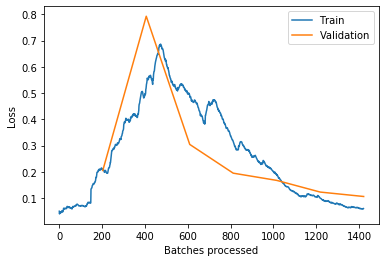

In [57]:
print("Plotting Losses")
learn.recorder.plot_losses()

Plotting metrics


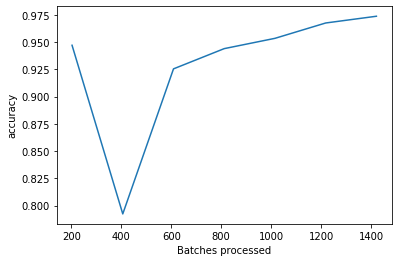

In [58]:
print("Plotting metrics")
learn.recorder.plot_metrics()

Plotting LR


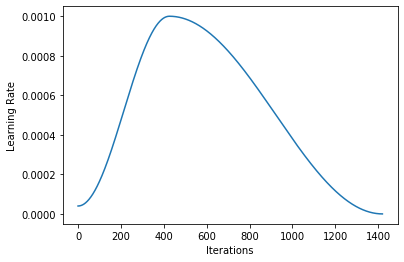

In [59]:
print("Plotting LR")
learn.recorder.plot_lr()

In [0]:
learn.load('gabor-VGG16-weight-5');

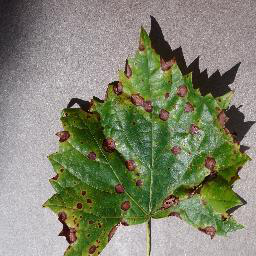

In [61]:
#/content/gdrive/My Drive/Datasets/PlantVillage/val/Grape___Black_rot/test.jpg
#/content/gdrive/My Drive/Datasets/PlantVillage/test.jpg
img = open_image(Path('/content/gdrive/My Drive/Datasets/PlantVillage/val/Grape___Black_rot/test.jpg'))
img

In [62]:
print("Gabor Resnet time --------------")
%time pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Gabor Resnet time --------------
CPU times: user 156 ms, sys: 7.94 ms, total: 164 ms
Wall time: 330 ms


Category Grape___Esca_(Black_Measles)